# Calibration of the  spectra of CTIO Data in January 2017
==================================================================================================

- author : Sylvie Dagoret-Campagne
- affiliation : LAL/IN2P3/CNRS FRANCE
- date   : January 19th 2017
- update : January 25th 2017

- Does the calibration pixel -> wavelength using the result of the fit done previously.
- Put simulation and data in the same file.
- Wavelength binning is that of the SED

In [34]:
%%javascript
var kernel = IPython.notebook.kernel;
var thename = window.document.getElementById("notebook_name").innerHTML;
var command = "theNotebook = " + "'"+thename+"'";
kernel.execute(command);

<IPython.core.display.Javascript object>

In [35]:
print theNotebook

Calibrate_Spectrum_HD60753


In [36]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import matplotlib as mpl
from astropy.modeling import models
from astropy import units as u
from astropy import nddata
from astropy.io import fits
import re
import os

In [37]:
import ccdproc
print 'ccdproc version',ccdproc.__version__

from astropy.modeling import models

ccdproc version 1.0.1


In [38]:
from scipy import stats  
from scipy import ndimage
from datetime import datetime, timedelta
from mpl_toolkits.mplot3d import Axes3D
import scipy.signal

In [39]:
import bottleneck as bn  # numpy's masked median is slow...really slow (in version 1.8.1 and lower)
print 'bottleneck version',bn.__version__

bottleneck version 1.0.0


In [40]:
import photutils
from astropy.stats import sigma_clipped_stats
from photutils import daofind
from photutils import CircularAperture
from astropy.visualization import SqrtStretch
from astropy.visualization.mpl_normalize import ImageNormalize
#from photutils.background import Background2D
from photutils import Background2D, SigmaClip, MedianBackground

In [41]:
%load_ext Cython

The Cython extension is already loaded. To reload it, use:
  %reload_ext Cython


In [42]:
from IPython.display import Image, display

In [43]:
import matplotlib
matplotlib.rc('xtick', labelsize=20) 
matplotlib.rc('ytick', labelsize=20) 

In [44]:
# to enlarge the sizes
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (4, 4),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
plt.rcParams.update(params)

In [45]:
############################################################################
def ensure_dir(f):
    d = os.path.dirname(f)
    if not os.path.exists(f):
        os.makedirs(f)
#########################################################################

In [46]:
FIT_ORDER=2

### Output directory for images generated in the notebook view (not true fits images)

In [47]:
dir_top_images="images_notebooks/"+theNotebook ### Top directory to save images

In [48]:
ensure_dir(dir_top_images) # create that directory

### Input fits file

In [49]:
inputdir="./spectrum_fitsspec"
object_name='HD60753'

### Output fits file

In [50]:
outputdir="./spectrum_calibspec"

In [51]:
ensure_dir(outputdir)

### input simulation file

In [52]:
#simspecdir='/Users/dagoret-campagnesylvie/MacOsX/LSST/MyWork/GitHub/CTIOAna2016/simu_spectra/fits/HD14943_m10'
simspecdir='/Users/dagoret-campagnesylvie/MacOsX/LSST/MyWork/GitHub/CTIOAna2017/simu_spectra/fits/HD14943/2017_01_17/092_195'

In [53]:
simspectrasummary='AllSimSpectra_'+object_name+'.fits'

In [54]:
simspectracalibresult='SpecCalibFitResults_'+object_name +'.fits'

## Load the Fits results for the calibration

In [55]:
hdu_list=fits.open(simspectracalibresult)
hdu_list.info()

Filename: SpecCalibFitResults_HD60753.fits
No.    Name         Type      Cards   Dimensions   Format
  0  PRIMARY     PrimaryHDU       7   ()      
  1              ImageHDU         7   (3, 84)   float64   
  2              ImageHDU         7   (3, 84)   float64   


In [56]:
print hdu_list[0].header

SIMPLE  =                    T / conforms to FITS standard                      BITPIX  =                    8 / array data type                                NAXIS   =                    0 / number of array dimensions                     EXTEND  =                    T                                                  ANALYST = 'Sylvie Dagoret-Campagne'                                             OBJ-NAME= 'HD60753 '                                                            COMMENT Fits straight line on spectra                                           END                                                                                                                                                                                                                                                                                                                                                                                                                                                     

In [57]:
fitparam_rightspectra=hdu_list[1].data
fitparam_leftspectra=hdu_list[2].data

In [58]:
#fitparam_rightspectra

## Location of corrected images
----------------------------------

In [59]:
input_filelist=os.listdir(inputdir) 

In [60]:
if '.DS_Store' in input_filelist:
    input_filelist.remove('.DS_Store')
input_filelist=np.array(input_filelist)

In [61]:
print input_filelist[0:5]

['finalSpectra_HD60753_20170117_210.fits'
 'finalSpectra_HD60753_20170117_211.fits'
 'finalSpectra_HD60753_20170117_212.fits'
 'finalSpectra_HD60753_20170117_213.fits'
 'finalSpectra_HD60753_20170117_214.fits']


In [62]:
indexes_files= [] # global list
filelist_fitsimages= []  # global list

In [63]:
#%%cython

import numpy as np
import re

def MakeFileList(inputdir,input_filelist):
    """
    MakeFileList : Make The List of files to open
    =============
    """
    
#    import numpy as np
#    import re
    indexes_files= [] # global list
    filelist_fitsimages= []  # global list

    

    for file in input_filelist: # loop on directories, one per image       
            filename=inputdir+'/'+file
            if re.search('.*fits$',filename):  #example of filename filter
                num_str=re.findall('^finalSpectra_HD60753_20170117_([0-9]+).fits',file)[0]
                index=int(num_str)
                filelist_fitsimages.append(filename)
                indexes_files.append(index)
    return indexes_files, filelist_fitsimages   


In [64]:
indexes_files, filelist_fitsimages=MakeFileList(inputdir,input_filelist)   # filter to select fits file only

In [65]:
# transform into numpy arrays
indexes_files=np.array(indexes_files)
filelist_fitsimages=np.array(filelist_fitsimages)

In [66]:
print indexes_files

[210 211 212 213 214 215 216 217 218 219 220 221 222 223 224 225 226 227
 228 229 230 231 232 233 234 235 236 237 238 239 240 241 242 243 244 245
 246 247 248 249 250 251 252 253 254 255 256 257 258 259 260 261 262 263
 264 265 266 267 268 269 270 271 272 273 274 275 276 277 278 279 280 281
 282 283 284 285 286 287 288 289 290 291 292 293]


In [67]:
sorted_indexes=np.argsort(indexes_files) # sort the file indexes

In [68]:
sorted_numbers=indexes_files[sorted_indexes]

In [69]:
print sorted_indexes

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49
 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74
 75 76 77 78 79 80 81 82 83]


In [70]:
#sorted_files= [filelist_fitsimages[index] for index in sorted_indexes] # sort files
sorted_files=filelist_fitsimages[sorted_indexes]

In [71]:
sorted_files[0:5]

array(['./spectrum_fitsspec/finalSpectra_HD60753_20170117_210.fits',
       './spectrum_fitsspec/finalSpectra_HD60753_20170117_211.fits',
       './spectrum_fitsspec/finalSpectra_HD60753_20170117_212.fits',
       './spectrum_fitsspec/finalSpectra_HD60753_20170117_213.fits',
       './spectrum_fitsspec/finalSpectra_HD60753_20170117_214.fits'], 
      dtype='|S58')

## Build full filename
----------------------------

In [72]:
sorted_filenames=[]
for file in sorted_files:
    #fullfilename=os.path.join(inputdir,file)
    fullfilename=file
    sorted_filenames.append(fullfilename)

In [73]:
#sorted_filenames=np.array(sorted_filenames)
sorted_filenames=np.copy(sorted_files)

In [74]:
print sorted_filenames.shape

(84,)


## Acces to spectrum data
----------------------------------

In [75]:
all_dates = []
all_airmass = []
all_spectra = []
all_titles = []
all_header = []
all_img = []

In [76]:
%%cython

import numpy as np
from astropy.io import fits

def BuildRawSpec(sorted_filenames,sorted_numbers,object_name):
    """
    BuildRawSpec
    ===============
    """

    all_dates = []
    all_airmass = []
    all_leftspectra = []
    all_rightspectra = []
    all_titles = []
    all_header = []
    all_expo = []
   
    NBFILES=sorted_filenames.shape[0]

    for idx in range(NBFILES):  
        
        file=sorted_filenames[idx]    
        
        hdu_list=fits.open(file)
        header=hdu_list[0].header
        #print header
        date_obs = header['DATE-OBS']
        airmass = header['AIRMASS']
        expo = header['EXPTIME']
        num=sorted_numbers[idx]
        title=object_name+" z= {:3.2f} Nb={}".format(float(airmass),num)
        
        # now reads the spectra
        
        table_data=hdu_list[1].data
        
        left_spectrum=table_data.field('RawLeftSpec')
        right_spectrum=table_data.field('RawRightSpec')
        
        all_dates.append(date_obs)
        all_airmass.append(float(airmass))
        all_leftspectra.append(left_spectrum)
        all_rightspectra.append(right_spectrum)
        all_titles.append(title)
        all_header.append(header)
        all_expo.append(expo)
        hdu_list.close()
        
    return all_dates,all_airmass,all_titles,all_header,all_expo,all_leftspectra,all_rightspectra

In [77]:
all_dates,all_airmass,all_titles,all_header,all_expo,all_leftspectra,all_rightspectra=BuildRawSpec(sorted_files,sorted_numbers,object_name)

## Show Spectra
-----------------------

In [78]:
len(all_rightspectra)

84

In [79]:
%%cython
import numpy as np
import matplotlib.pyplot as plt
import os

def ShowSpectra(all_spectra,all_titles,object_name,dir_top_images,figname):
    """
    ShowSpectra: Show the raw images without background subtraction
    ==============
    """
    NBIMAGES=len(all_spectra)
    MAXIMGROW=int(NBIMAGES/5)+1
    thex0 = []
    f, axarr = plt.subplots(MAXIMGROW,5,figsize=(25,60))
    f.tight_layout()
    #plt.subplot_tool() 
    for index in np.arange(0,NBIMAGES):
        ix=index%5
        iy=index/5
        spectrum=all_spectra[index]
        axarr[iy,ix].plot(spectrum,'r-',lw=2)
        axarr[iy,ix].set_title(all_titles[index])
        #axarr[iy,ix].set_ylim(0.,200.)
        #axarr[iy,ix].set_xlim(0.,500.)
        axarr[iy,ix].grid(True)
      
    title='calibrated spectra'
    plt.suptitle(title,size=16)
    
    figfilename=os.path.join(dir_top_images,figname)
    plt.savefig(figfilename)

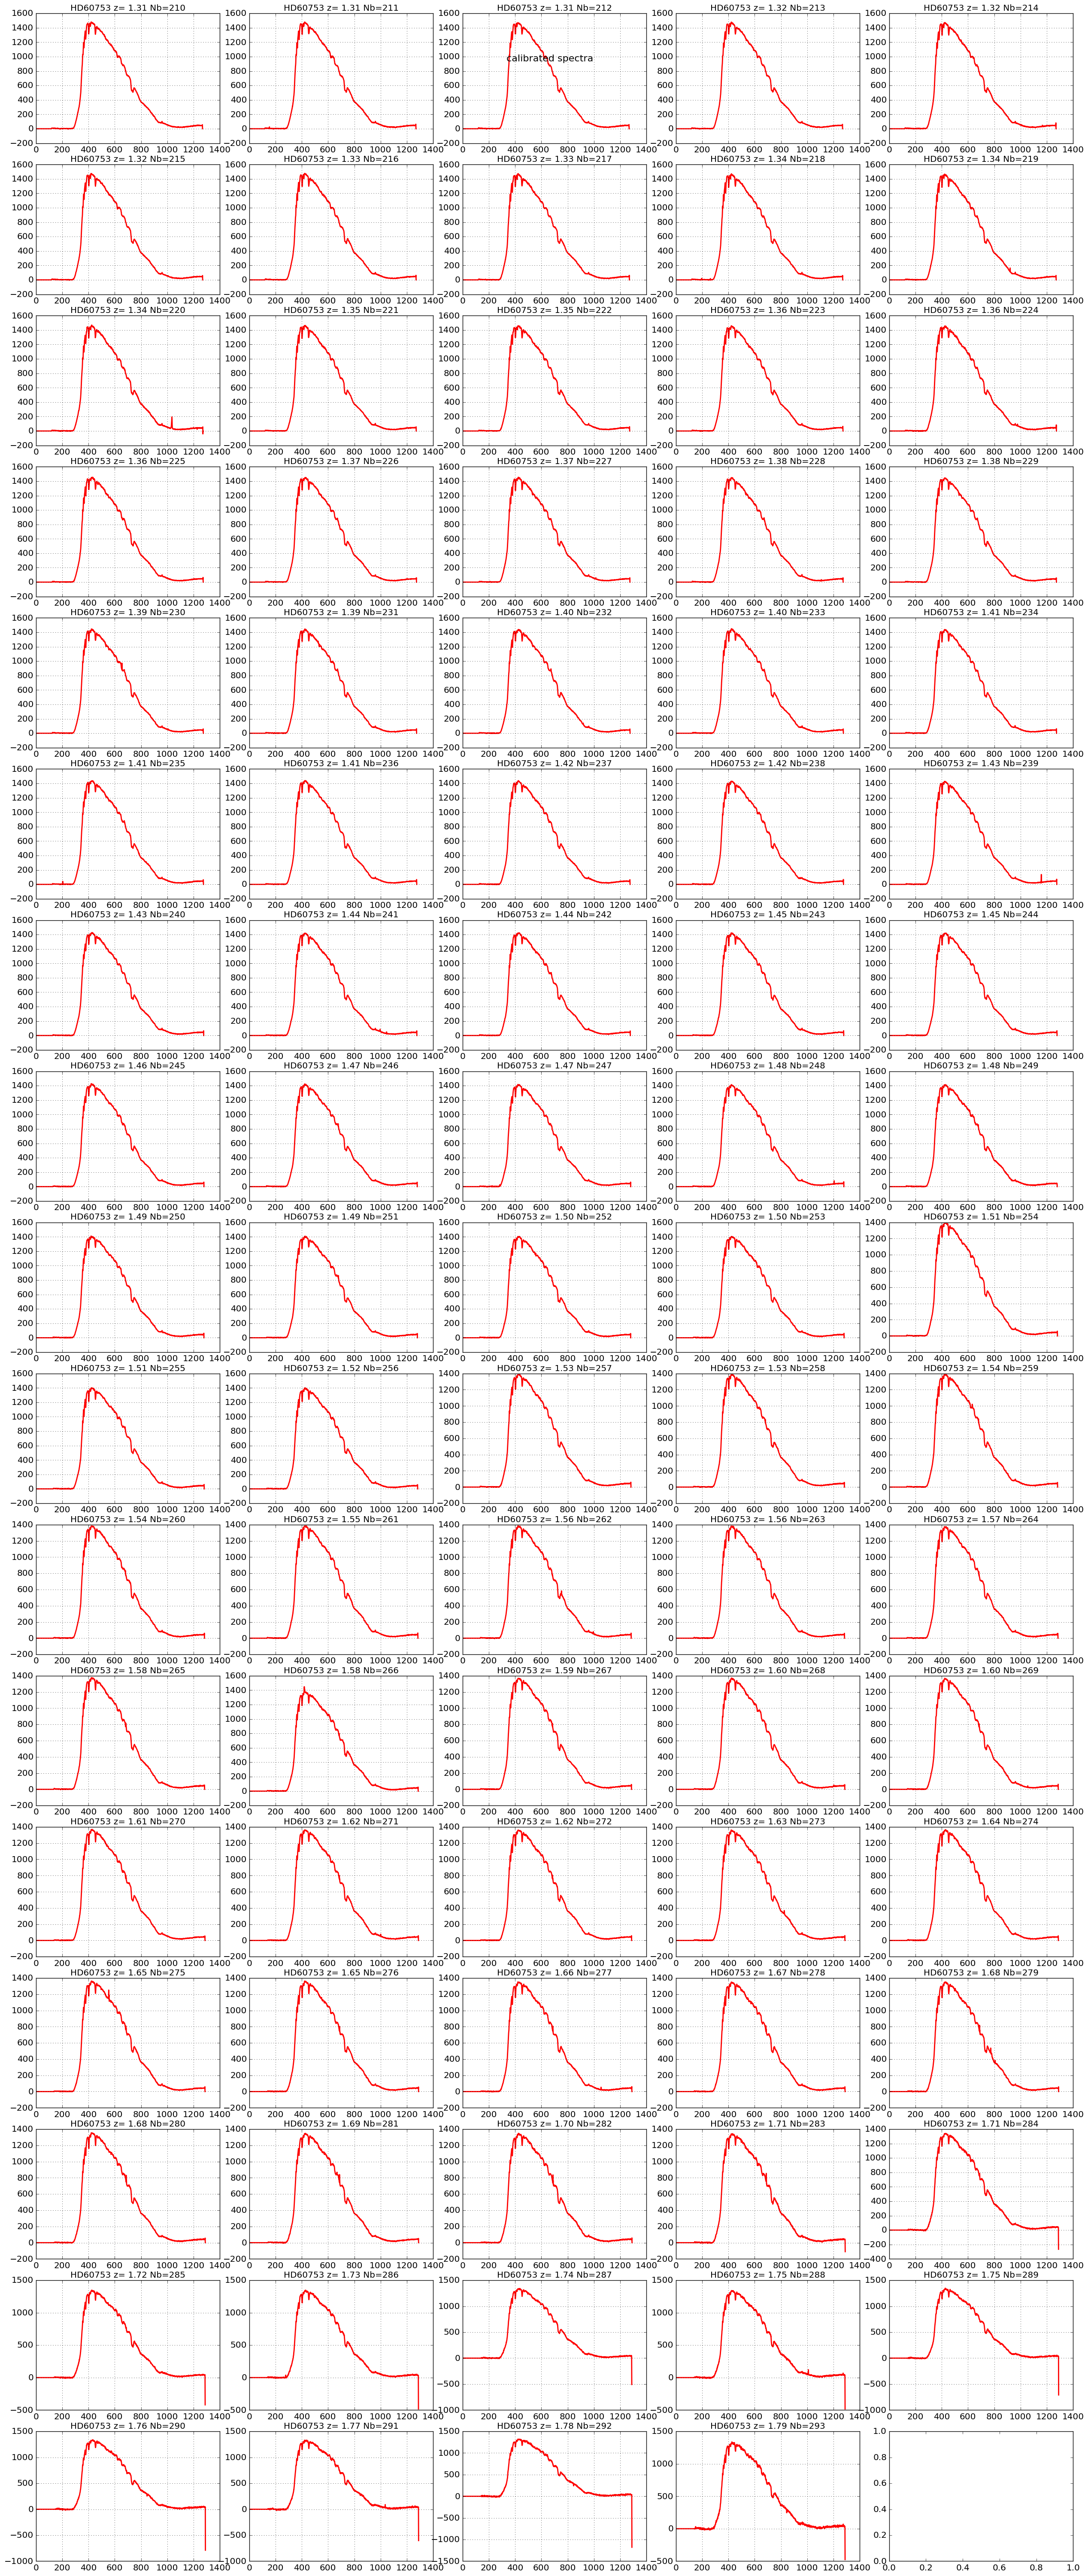

In [80]:
ShowSpectra(all_rightspectra,all_titles,object_name,dir_top_images,'calrightspectra.pdf')

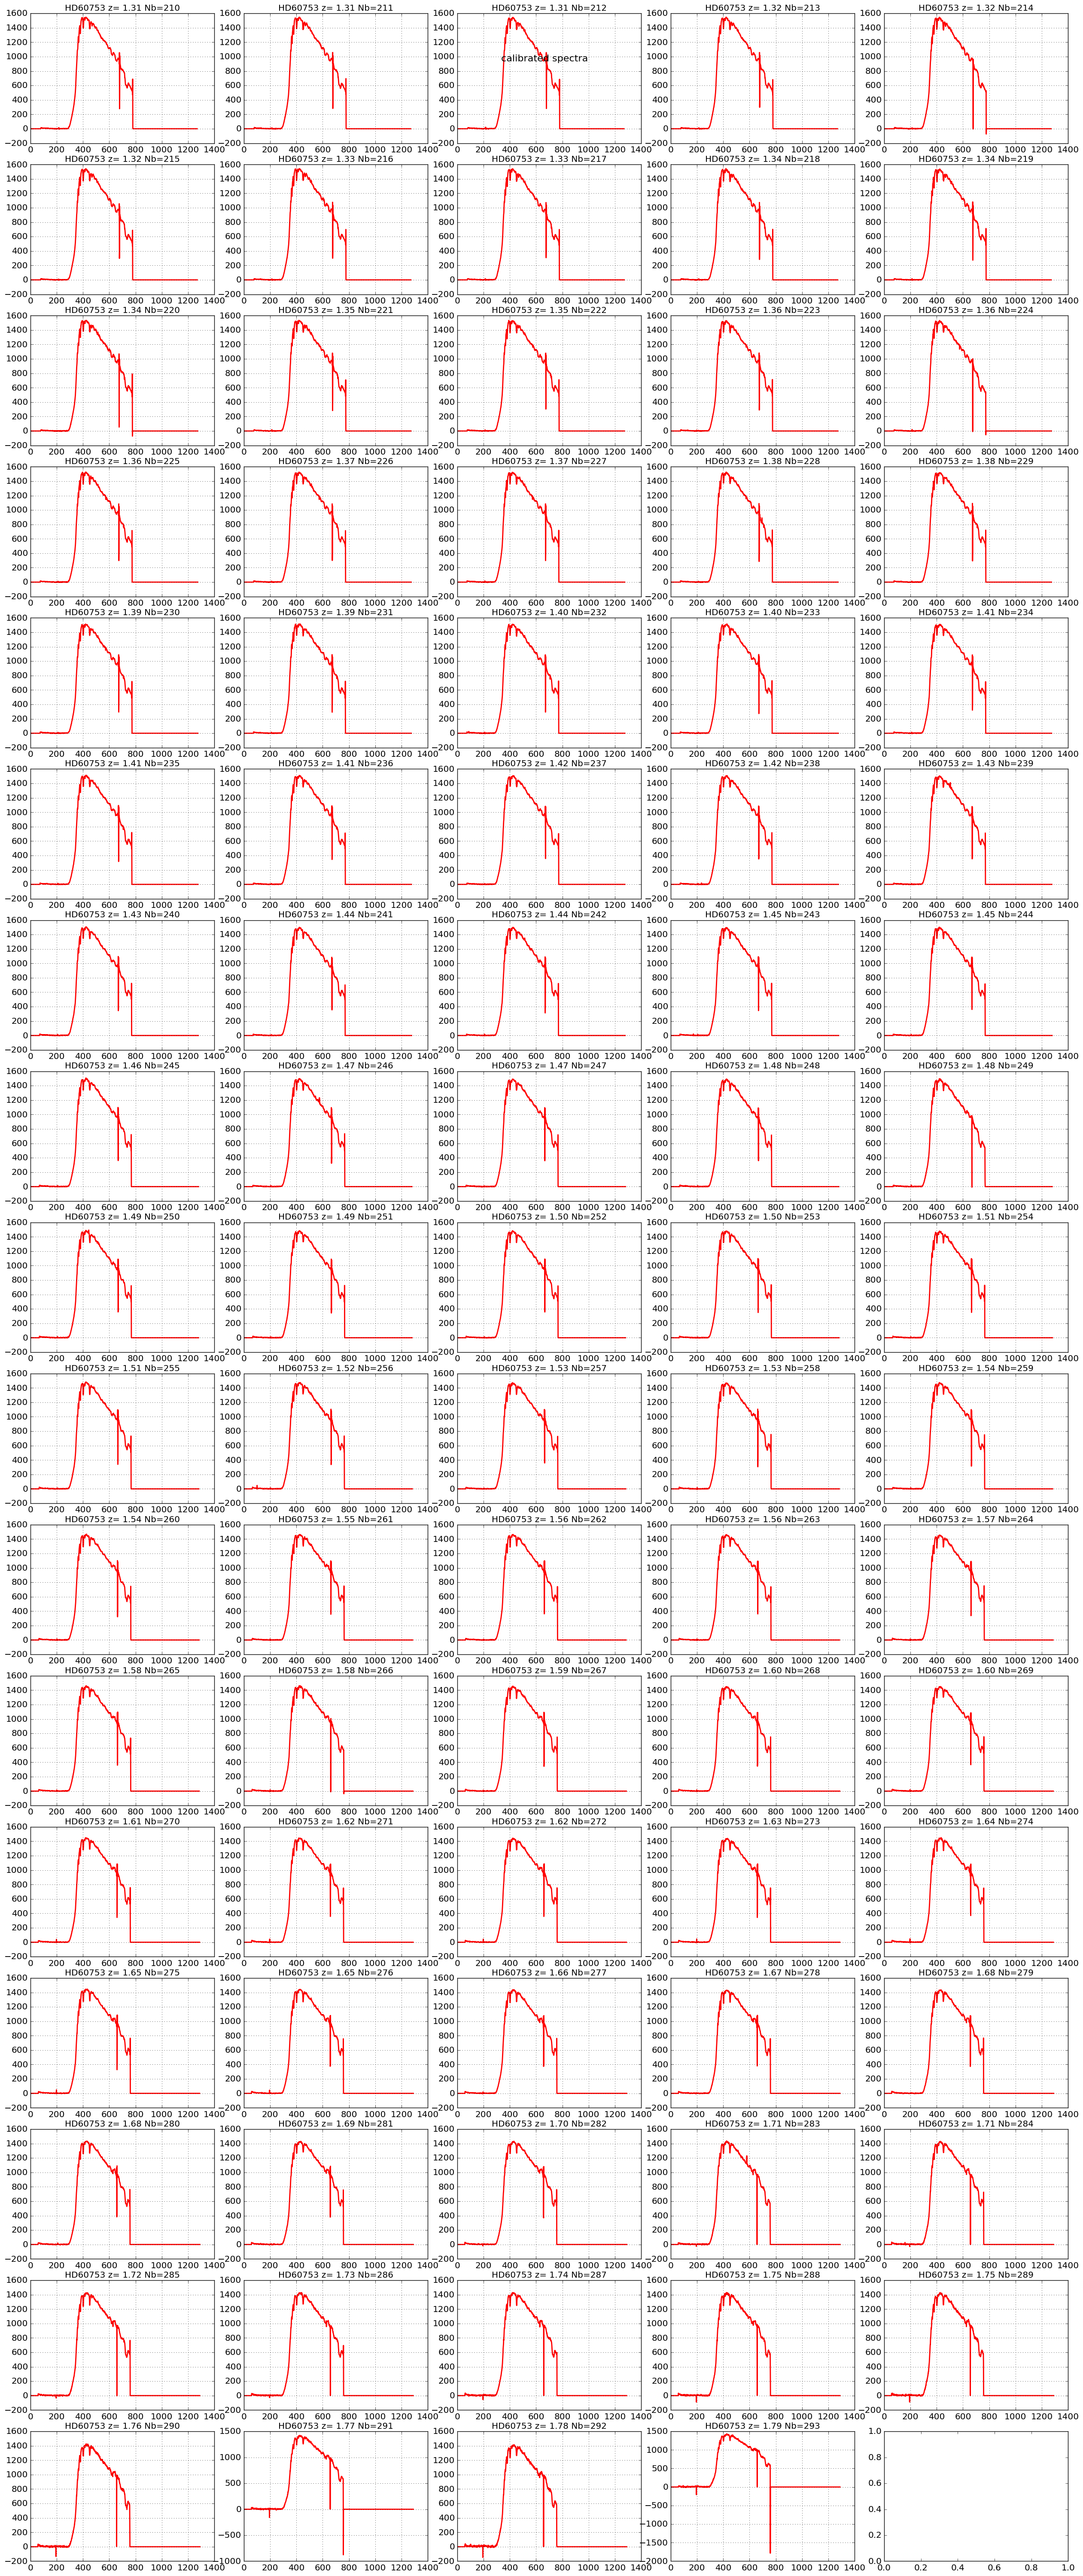

In [81]:
ShowSpectra(all_leftspectra,all_titles,object_name,dir_top_images,'calleftspectra.pdf')

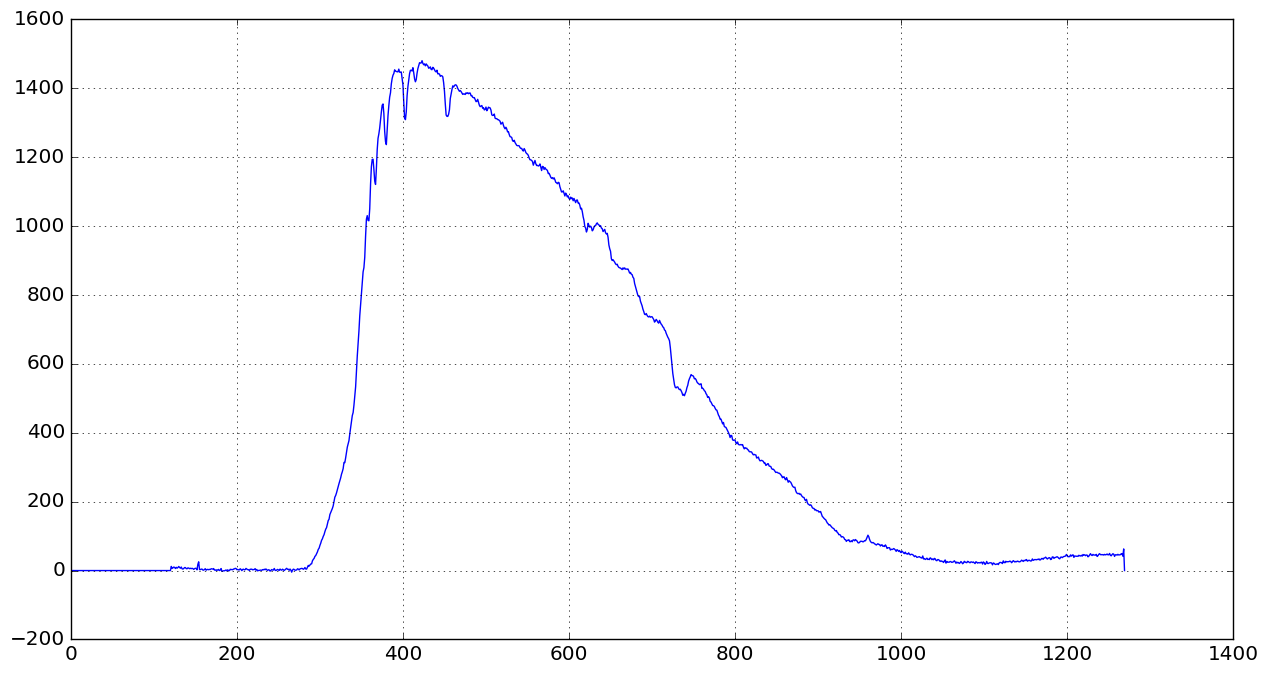

In [82]:
plt.figure(figsize=(15,8))
plt.plot(all_rightspectra[1])
#plt.xlim(0,500)
plt.grid(True)

## Read the simulated spectra

In [83]:
inputsim_filelist=os.listdir(simspecdir) 

In [84]:
if '.DS_Store' in inputsim_filelist:
    inputsim_filelist.remove('.DS_Store')
inputsim_filelist=np.array(inputsim_filelist)

In [85]:
print inputsim_filelist[0:5]

['RT_CT_pp_us_sa_rt_HD14943_Nev100_y2016_m01_aver_spectra.fits'
 'RT_CT_pp_us_sa_rt_HD14943_Nev101_y2016_m01_aver_spectra.fits'
 'RT_CT_pp_us_sa_rt_HD14943_Nev102_y2016_m01_aver_spectra.fits'
 'RT_CT_pp_us_sa_rt_HD14943_Nev103_y2016_m01_aver_spectra.fits'
 'RT_CT_pp_us_sa_rt_HD14943_Nev104_y2016_m01_aver_spectra.fits']


In [86]:
print re.findall('^RT_CT_pp_us_sa_rt_HD14943_Nev(.*)_y2016_m01_aver_spectra.fits',inputsim_filelist[0])

['100']


In [87]:
indexes_simfiles= [] # global list
filelist_simfitspec= []  # global list

In [88]:
#%%cython

import numpy as np
import re

def MakeSimFileList(inputdir,input_filelist):
    """
    MakeFileList : Make The List of files to open
    =============
    """
    
#    import numpy as np
#    import re
    indexes_files= [] # global list
    filelist_fitsimages= []  # global list
    index=0

    
    for file in input_filelist: # loop on directories, one per image       
            filename=inputdir+'/'+file
            if re.search('.*fits$',filename):  #example of filename filter
                index=index+1
                filelist_fitsimages.append(filename)
                str_num=re.findall('^RT_CT_pp_us_sa_rt_HD14943_Nev(.*)_y2016_m01_aver_spectra.fits',file)
                number=int(str_num[0])
                indexes_files.append(number)
    return indexes_files, filelist_fitsimages

In [89]:
indexes_simfiles, filelist_simfitspec=MakeSimFileList(simspecdir,inputsim_filelist)   # filter to take only fits file

In [90]:
# transform into numpy arrays
indexes_simfiles=np.array(indexes_simfiles)
filelist_simfitspec=np.array(filelist_simfitspec)

In [91]:
print indexes_simfiles

[100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117
 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135
 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153
 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171
 172 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187 188 189
 190 191 192 193 194 195  92  93  94  95  96  97  98  99]


In [92]:
sorted_simindexes=np.argsort(indexes_simfiles) # sort the file indexes

In [93]:
sorted_simindexes

array([ 96,  97,  98,  99, 100, 101, 102, 103,   0,   1,   2,   3,   4,
         5,   6,   7,   8,   9,  10,  11,  12,  13,  14,  15,  16,  17,
        18,  19,  20,  21,  22,  23,  24,  25,  26,  27,  28,  29,  30,
        31,  32,  33,  34,  35,  36,  37,  38,  39,  40,  41,  42,  43,
        44,  45,  46,  47,  48,  49,  50,  51,  52,  53,  54,  55,  56,
        57,  58,  59,  60,  61,  62,  63,  64,  65,  66,  67,  68,  69,
        70,  71,  72,  73,  74,  75,  76,  77,  78,  79,  80,  81,  82,
        83,  84,  85,  86,  87,  88,  89,  90,  91,  92,  93,  94,  95])

In [94]:
sorted_simnumbers=indexes_simfiles[sorted_simindexes] # check the ordering with argsort is correct

In [95]:
print sorted_simnumbers # check

[ 92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108 109
 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127
 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145
 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163
 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181
 182 183 184 185 186 187 188 189 190 191 192 193 194 195]


In [96]:
sorted_simfiles=filelist_simfitspec[sorted_simindexes] # now sort the filenames

In [97]:
print sorted_simfiles[0:5] # check

[ '/Users/dagoret-campagnesylvie/MacOsX/LSST/MyWork/GitHub/CTIOAna2017/simu_spectra/fits/HD14943/2017_01_17/092_195/RT_CT_pp_us_sa_rt_HD14943_Nev92_y2016_m01_aver_spectra.fits'
 '/Users/dagoret-campagnesylvie/MacOsX/LSST/MyWork/GitHub/CTIOAna2017/simu_spectra/fits/HD14943/2017_01_17/092_195/RT_CT_pp_us_sa_rt_HD14943_Nev93_y2016_m01_aver_spectra.fits'
 '/Users/dagoret-campagnesylvie/MacOsX/LSST/MyWork/GitHub/CTIOAna2017/simu_spectra/fits/HD14943/2017_01_17/092_195/RT_CT_pp_us_sa_rt_HD14943_Nev94_y2016_m01_aver_spectra.fits'
 '/Users/dagoret-campagnesylvie/MacOsX/LSST/MyWork/GitHub/CTIOAna2017/simu_spectra/fits/HD14943/2017_01_17/092_195/RT_CT_pp_us_sa_rt_HD14943_Nev95_y2016_m01_aver_spectra.fits'
 '/Users/dagoret-campagnesylvie/MacOsX/LSST/MyWork/GitHub/CTIOAna2017/simu_spectra/fits/HD14943/2017_01_17/092_195/RT_CT_pp_us_sa_rt_HD14943_Nev96_y2016_m01_aver_spectra.fits']


In [98]:
hdu_list=fits.open(sorted_simfiles[49])
header=hdu_list[0].header

In [99]:
print header

SIMPLE  =                    T / conforms to FITS standard                      BITPIX  =                    8 / array data type                                NAXIS   =                    0 / number of array dimensions                     EXTEND  =                    T                                                  OBJ_NAME= 'HD14943 '                                                            AIRMASS =    1.550999999046326                                                  UNITS   = 'wavelength in nm'                                                    DATE    = '2017-01-18T03:24:28.003'                                             EXPOSURE=                 30.0                                                  FILENAME= 'trim_20170117_141.fits'                                              COMMENT Prediction of observable SPECTRA                                        END                                                                                                                     

In [100]:
 table_data=hdu_list[1].data

In [101]:
print table_data.columns

ColDefs(
    name = 'WAVELENGTH'; format = 'E'
    name = 'SEDcalspec'; format = 'E'
    name = 'Atmosphere'; format = 'E'
    name = 'QE'; format = 'E'
    name = 'SEDxQExATM'; format = 'E'
)


In [102]:
simwavelength = table_data.field('WAVELENGTH')
simsed        = table_data.field('SEDcalspec')
simatm        = table_data.field('Atmosphere')
simqe         = table_data.field('QE')
simspectra    = table_data.field('SEDxQExATM')

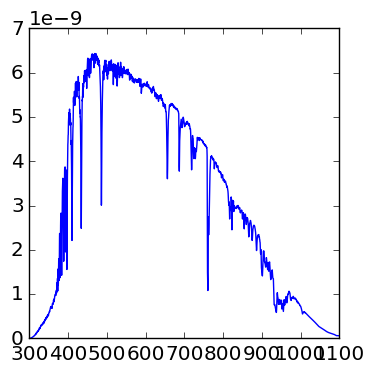

In [103]:
plt.plot(simwavelength,simspectra )

In [104]:
#%%cython

#import numpy as np
#from astropy.io import fits
def BuildSimSpec(sorted_filenames,sorted_numbers,object_name):
    """
    BuildSimSpec
    ===============
    """

    all_dates = []
    all_airmass = []
    
    all_simwavelength = []
    all_simspectra = []
    all_simatmosphere = []
    all_simqe = []
    all_simsed = []
    
    all_titles = []
    all_header = []
    all_expo = []
   
    NBFILES=sorted_filenames.shape[0]

    for idx in range(NBFILES):  
        
        print idx
        
        file=sorted_filenames[idx]    
        
        hdu_list=fits.open(file)
        header=hdu_list[0].header
                
        #print header
        date_obs = header['DATE']
        airmass = header['AIRMASS']
        expo = header['EXPOSURE']
        num=sorted_numbers[idx]
        title=object_name+" z= {:3.2f} Nb={}".format(float(airmass),num)
        
        # now reads the spectra
        
        table_data=hdu_list[1].data
        
        simwavelength = table_data.field('WAVELENGTH')
        simsed        = table_data.field('SEDcalspec')
        simatm        = table_data.field('Atmosphere')
        simqe         = table_data.field('QE')
        simspectra    = table_data.field('SEDxQExATM')
        
        
        all_simwavelength.append(simwavelength)
        all_simspectra.append(simspectra)
        all_simatmosphere.append(simatm)
        all_simqe.append(simqe)
        all_simsed.append(simsed)
        
        all_dates.append(date_obs)
        all_airmass.append(float(airmass))
            
        all_titles.append(title)
        all_header.append(header)
        all_expo.append(expo)
        hdu_list.close()
        
    return all_dates,all_airmass,all_titles,all_header,all_expo,all_simwavelength,all_simspectra,all_simatmosphere,all_simqe,all_simsed

In [105]:
# crash because it blows up fits IO capability : too many files open
#all_simdates,all_simairmass,all_simtitles,all_simheader,all_simexpo,all_simwavelength,all_simspectra,all_simatmosphere,all_simqe,all_simsed=BuildSimSpec(sorted_simfiles,sorted_simnumbers,object_name)

In [106]:
# better open a singel file produced by view_SimSpectrum

hdu_list=fits.open(simspectrasummary)
header=hdu_list[0].header
print header
simspectra_data=hdu_list[0].data

SIMPLE  =                    T / conforms to FITS standard                      BITPIX  =                  -64 / array data type                                NAXIS   =                    2 / number of array dimensions                     NAXIS1  =                 1894                                                  NAXIS2  =                   85                                                  EXTEND  =                    T                                                  END                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                     

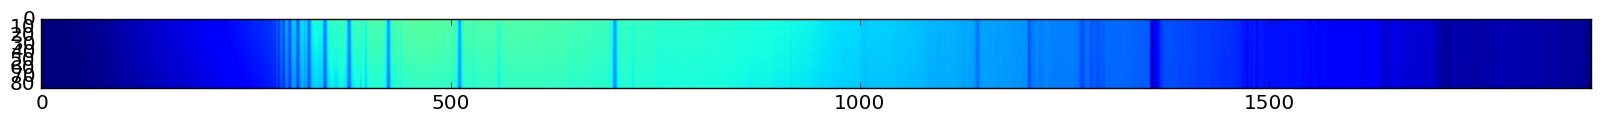

In [107]:
plt.figure(figsize=(20,20))
plt.imshow(simspectra_data[:,:],vmin=0,vmax=8e-9)

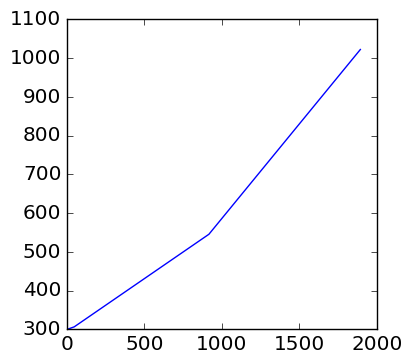

In [108]:
plt.plot(simspectra_data[0,:])
wl_simspectra=simspectra_data[0,:]

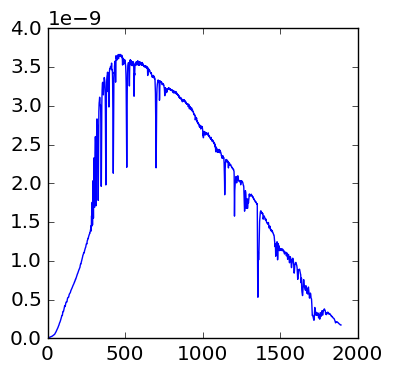

In [109]:
plt.plot(simspectra_data[2,:])

In [110]:
wl_O2Aline=759.37
wl_O2Bline=686.719
wl_Haline=656.281 
wl_Hbline=486.134
wl_Hgline=434.047 
wl_Hdline=410.175

#wl_Naline=589.592+1
#wl_Heline=587.5618-1


#wl_Hgline=546.073
#wl_Feline=527.039
wl_calib= np.array([wl_O2Aline, wl_Haline, wl_Hbline, wl_Hgline ])

## Comparison of spectra

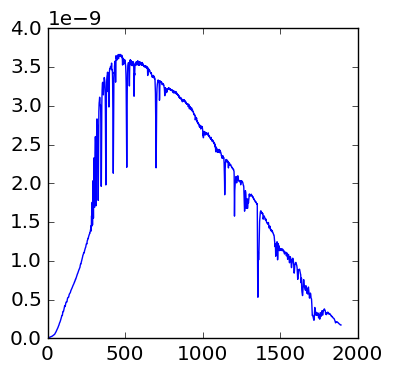

In [111]:
plt.plot(simspectra_data[2,:])

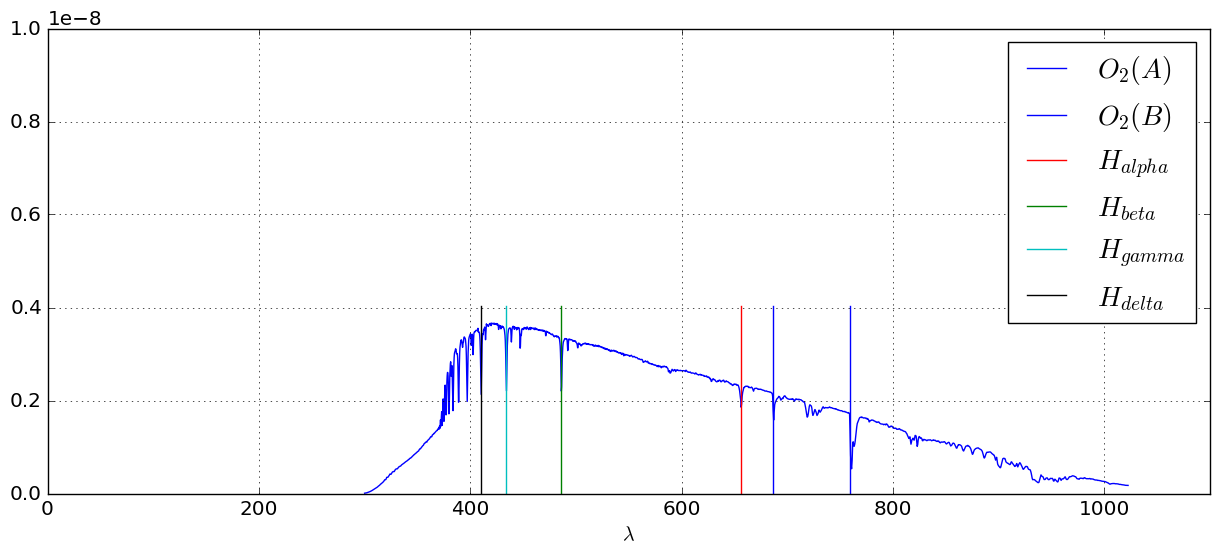

In [112]:
ymax=simspectra_data[2,:].max()*1.1
ymin=simspectra_data[2,:].min()
plt.figure(figsize=(15,6))
plt.plot(simspectra_data[0,:],simspectra_data[2,:])

plt.plot([wl_O2Aline,wl_O2Aline],[ymin,ymax],'b-',label='$O_2(A)$',lw=1)
plt.plot([wl_O2Bline,wl_O2Bline],[ymin,ymax],'b-',label='$O_2(B)$',lw=1)
plt.plot([wl_Haline,wl_Haline],[ymin,ymax],'r-',label='$H_{alpha}$',lw=1)
plt.plot([wl_Hbline,wl_Hbline],[ymin,ymax],'g-',label='$H_{beta}$',lw=1)
plt.plot([wl_Hgline,wl_Hgline],[ymin,ymax],'c-',label='$H_{gamma}$',lw=1)
plt.plot([wl_Hdline,wl_Hdline],[ymin,ymax],'k-',label='$H_{delta}$',lw=1)

plt.legend(loc='best',fontsize=20)
plt.ylim(0.,1e-8)
plt.xlim(0,1100)
plt.xlabel("$\lambda$")
plt.grid(True)

In [113]:
#%%cython
#import numpy as np
#import matplotlib.pyplot as plt
#import matplotlib as mpl    
def CalibrateSpectra(all_spectra,fit_param,all_titles,object_name,figname):
    """
    CalibrateSpectra(all_spectra,fit_param,all_titles,object_name): 
    ==============
    """

    NBSPECTRA=len(all_spectra)
    MAXIMGROW=int(NBSPECTRA/5)+1
    
    NBWL=all_spectra[0].shape[0]
    
    all_wl=[]
    
    
    f, axarr = plt.subplots(MAXIMGROW,5,figsize=(25,60))
    f.tight_layout()

    for index in np.arange(0,NBSPECTRA):
        ix=index%5
        iy=index/5
        spectrum=all_spectra[index]
        spectrum_pix=np.arange(0,spectrum.shape[0])
        fitcurve = np.poly1d(fit_param[index])
        spectrum_wl=fitcurve(spectrum_pix)
        
        all_wl.append(spectrum_wl)
        
        ymax=spectrum.max()*1.1
        ymin=0
        
        axarr[iy,ix].plot(spectrum_wl,spectrum,'b-',lw=2)
        axarr[iy,ix].set_title(all_titles[index])
        axarr[iy,ix].set_ylim(ymin,ymax)
        axarr[iy,ix].set_xlim(0.,1000.)
        axarr[iy,ix].grid(True)

        axarr[iy,ix].get_xaxis().set_minor_locator(mpl.ticker.AutoMinorLocator())
        axarr[iy,ix].get_yaxis().set_minor_locator(mpl.ticker.AutoMinorLocator())
        axarr[iy,ix].grid(b=True, which='major', color='k', linewidth=2.0)
        axarr[iy,ix].grid(b=True, which='minor', color='k', linewidth=0.5)
        
        axarr[iy,ix].plot([wl_O2Aline,wl_O2Aline],[ymin,ymax],'b-',label='$O_2(A)$',lw=1)
        axarr[iy,ix].plot([wl_Haline,wl_Haline],[ymin,ymax],'r-',label='$H_{alpha}$',lw=1)
        axarr[iy,ix].plot([wl_Hbline,wl_Hbline],[ymin,ymax],'g-',label='$H_{beta}$',lw=1)
        axarr[iy,ix].plot([wl_Hgline,wl_Hgline],[ymin,ymax],'c-',label='$H_{gamma}$',lw=1)
        
        figfilename=os.path.join(dir_top_images,figname)
        plt.savefig(figfilename)
        
    return all_wl
        

In [ ]:
#import numpy as np
#import matplotlib.pyplot as plt
#import matplotlib as mpl    
def CalibrateSpectra2(all_spectra,fit_param,all_titles,object_name,figname):
    """
    CalibrateSpectra2: Show the camibration curve
    ==============
    """

    NBSPECTRA=len(all_spectra)
    NBWL=all_spectra[0].shape[0]
    all_wl= []
    
    fig, ax = plt.subplots(1, 1, figsize=(15,8))

    all_ymin= []
    all_ymax=[]
    
    for index in np.arange(0,NBSPECTRA):
        if index==0 :  # Skip first
            continue
        ix=index%5
        iy=index/5
        
           
        spectrum=all_spectra[index]
        
        all_ymin.append(spectrum.min())
        all_ymax.append(spectrum.max())
        
        spectrum_pix=np.arange(0,spectrum.shape[0])
        fitcurve = np.poly1d(fit_param[index])
        spectrum_wl=fitcurve(spectrum_pix)
        
        all_wl.append(spectrum_wl)
        
        ax.plot(spectrum_wl,spectrum,'-',lw=2)
       
    ymin=np.array(all_ymin).min() 
    ymax=np.array(all_ymax).max()*1.1   
        
    #ax.set_xlim(0.,1000.)
    ax.set_ylim(0,100)
    
    ax.plot([wl_O2Aline,wl_O2Aline],[ymin,ymax],'b-',label='$O_2(A)$',lw=1)
    ax.plot([wl_Haline,wl_Haline],[ymin,ymax],'r-',label='$H_{alpha}$',lw=1)
    ax.plot([wl_Hbline,wl_Hbline],[ymin,ymax],'g-',label='$H_{beta}$',lw=1)
    ax.plot([wl_Hgline,wl_Hgline],[ymin,ymax],'c-',label='$H_{gamma}$',lw=1)

    ax.get_xaxis().set_minor_locator(mpl.ticker.AutoMinorLocator())
    ax.get_yaxis().set_minor_locator(mpl.ticker.AutoMinorLocator())
    ax.grid(b=True, which='major', color='k', linewidth=2.0)
    ax.grid(b=True, which='minor', color='k', linewidth=0.5)
    
    title='Calibrated Spectrum for object {}'.format(object_name)
    
    ax.set_title(title)
    ax.set_ylabel("spectrum")
    ax.set_xlabel("$\lambda$ (nm)")
    
    figfilename=os.path.join(dir_top_images,figname)
    plt.savefig(figfilename)
    
    return all_wl 
       

In [ ]:
calibrated_rightspectra_wl=CalibrateSpectra(all_rightspectra,fitparam_rightspectra,all_titles,object_name,'calrightspectra1.pdf')


In [ ]:
calibrated_rightspectra_wl[1]

In [ ]:
calibrated_rightspectra_wl2=CalibrateSpectra2(all_rightspectra,fitparam_rightspectra,all_titles,object_name,'calrightspectra2.pdf')

In [ ]:
calibrated_leftspectra_wl=CalibrateSpectra(all_leftspectra,fitparam_leftspectra,all_titles,object_name,'calleftspectra1.pdf')

In [ ]:
calibrated_leftspectra_wl2=CalibrateSpectra2(all_leftspectra,fitparam_leftspectra,all_titles,object_name,'calleftspectra2.pdf')

### Save outputfilename
Results of the fits for right and left spectra are saved as images

In [ ]:
newfullfilenames=[]
for idx,file in np.ndenumerate(sorted_files):
    short_infilename=file.split("/")[2]
    short_partfilename=re.findall('^finalSpectra_(.*)',short_infilename)
    short_outfilename='calibSpectra_'+short_partfilename[0]
    newfullfilename=os.path.join(outputdir,short_outfilename)
    newfullfilenames.append(newfullfilename)

In [ ]:
newfullfilenames[0:5]

In [ ]:
#
#  New fashion to save a binary table outside the primary header
#
for idx,file in np.ndenumerate(newfullfilenames):
    primhdu = fits.PrimaryHDU(header=all_header[idx[0]])   # make an primary HDU without data
    
    col1=fits.Column(name='CalibLeftSpecWL',format='E',array=calibrated_leftspectra_wl[idx[0]])
    col2=fits.Column(name='CalibLeftSpec',format='E',array=all_leftspectra[idx[0]])
    col3=fits.Column(name='CalibLeftSpecFitParam',format='E',array=fitparam_leftspectra[idx[0]])
    col4=fits.Column(name='CalibRightSpecWL',format='E',array=calibrated_rightspectra_wl[idx[0]])
    col5=fits.Column(name='CalibRightSpec',format='E',array=all_rightspectra[idx[0]])
    col6=fits.Column(name='CalibRightSpecFitParam',format='E',array=fitparam_rightspectra[idx[0]])
    cols=fits.ColDefs([col1,col2,col3,col4,col5,col6])
    
    tbhdu = fits.BinTableHDU.from_columns(cols)     # new binary table HDU
    thdulist = fits.HDUList([primhdu, tbhdu])
    
    thdulist.writeto(file,clobber=True)